In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.ml import *
from pyspark.sql.functions import when, col

# Create a SparkSession
spark = SparkSession.builder \
    .appName("chatbot") \
    .getOrCreate()

In [2]:
path = 'D:\\Big_data\\nlu.csv'

* Hàm f (hàm có tham số) để tìm quy luật giữa x và y  => Giống như một hồ để kết dính
* Khi xử lý trên Big data thì dù xử lý trên máy tính hay cụm máy tính sẽ giống nhau

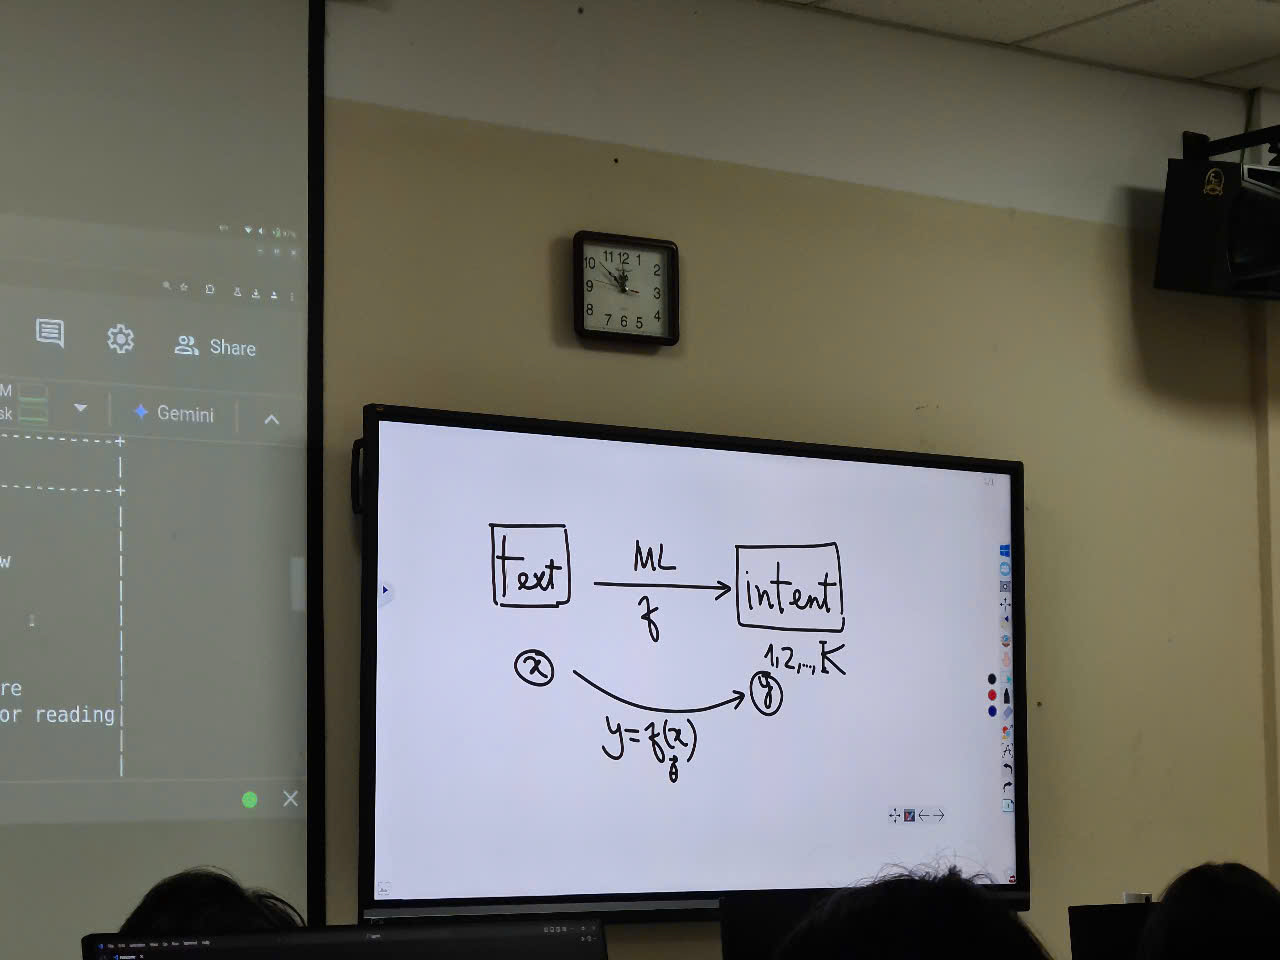

In [3]:
df = spark.read.option('header', True).option('delimiter', ';').csv(path)
df.show(5)

+------+--------+--------+-----------+------+--------------------+-----+------------------+--------------------+--------------------+--------------------+
|userid|answerid|scenario|     intent|status|   answer_annotation|notes|suggested_entities|   answer_normalised|              answer|            question|
+------+--------+--------+-----------+------+--------------------+-----+------------------+--------------------+--------------------+--------------------+
|     1|       1|   alarm|        set|  null|wake me up at [ti...| null|        date, time|wake me up at fiv...|wake me up at 5am...|Write what you wo...|
|     1|       2|   alarm|        set|  null|wake me up at [ti...| null|        date, time|wake me up at nin...|wake me up at 9am...|Write what you wo...|
|     1|       3|   alarm|        set|  null|set an alarm for ...| null|        date, time|set an alarm for ...|set an alarm for ...|Write what you wo...|
|     1|      31|   audio|volume_mute|  null|               quiet| nul

In [4]:
df.limit(10).toPandas().head()

,userid,answerid,scenario,intent,status,answer_annotation,notes,suggested_entities,answer_normalised,answer,question
0,1,1,alarm,set,null,wake me up at [time : five am] [date : this week],null,"date, time",wake me up at five am this week,wake me up at 5am this week,Write what you would tell your PDA in the foll...
1,1,2,alarm,set,null,wake me up at [time : nine am] on [date : friday],null,"date, time",wake me up at nine am on friday,wake me up at 9am on Friday,Write what you would tell your PDA in the foll...
2,1,3,alarm,set,null,set an alarm for [time : two hours from now],null,"date, time",set an alarm for two hours from now,set an alarm for two hours from now,Write what you would tell your PDA in the foll...
3,1,31,audio,volume_mute,null,quiet,null,player_setting,quiet,Olly quiet!,Write what you would tell your PDA in the foll...
4,1,32,audio,volume_mute,IRR_XL,stop,null,player_setting,stop,Stop!,Write what you would tell your PDA in the foll...


In [5]:
df.select('intent', 'answer_normalised').show(truncate=False)

+---------------+--------------------------------------------+
|intent         |answer_normalised                           |
+---------------+--------------------------------------------+
|set            |wake me up at five am this week             |
|set            |wake me up at nine am on friday             |
|set            |set an alarm for two hours from now         |
|volume_mute    |quiet                                       |
|volume_mute    |stop                                        |
|volume_mute    |pause for ten seconds                       |
|hue_lightchange|pink is all we need                         |
|hue_lightchange|make the lighting bit more warm here        |
|hue_lightchange|please set the lighting suitable for reading|
|hue_lightoff   |turn the lights off please                  |
|hue_lightoff   |time to sleep                               |
|hue_lighton    |and the darkness has fallen                 |
|hue_lightoff   |turn off the light in the bathroom    

In [6]:
df.count()

25716

In [7]:
df.select('intent').distinct().count()

54

In [8]:
df.filter(col('intent').isNull()).show()

+------+--------+--------+------+------+-----------------+-----+------------------+-----------------+------+--------+
|userid|answerid|scenario|intent|status|answer_annotation|notes|suggested_entities|answer_normalised|answer|question|
+------+--------+--------+------+------+-----------------+-----+------------------+-----------------+------+--------+
+------+--------+--------+------+------+-----------------+-----+------------------+-----------------+------+--------+



### Bước 1: Số hóa các text - String Indexer to Encode Intent

* Thao tác represent: Số hóa văn bản (text) thành dạng vector số => Các thuật toán sẽ khác nhau nếu ta có phương pháp biểu diễn các văn bản tốt
* Cách đơn giản nhất là count số từ trong 1 đoạn văn bản đó

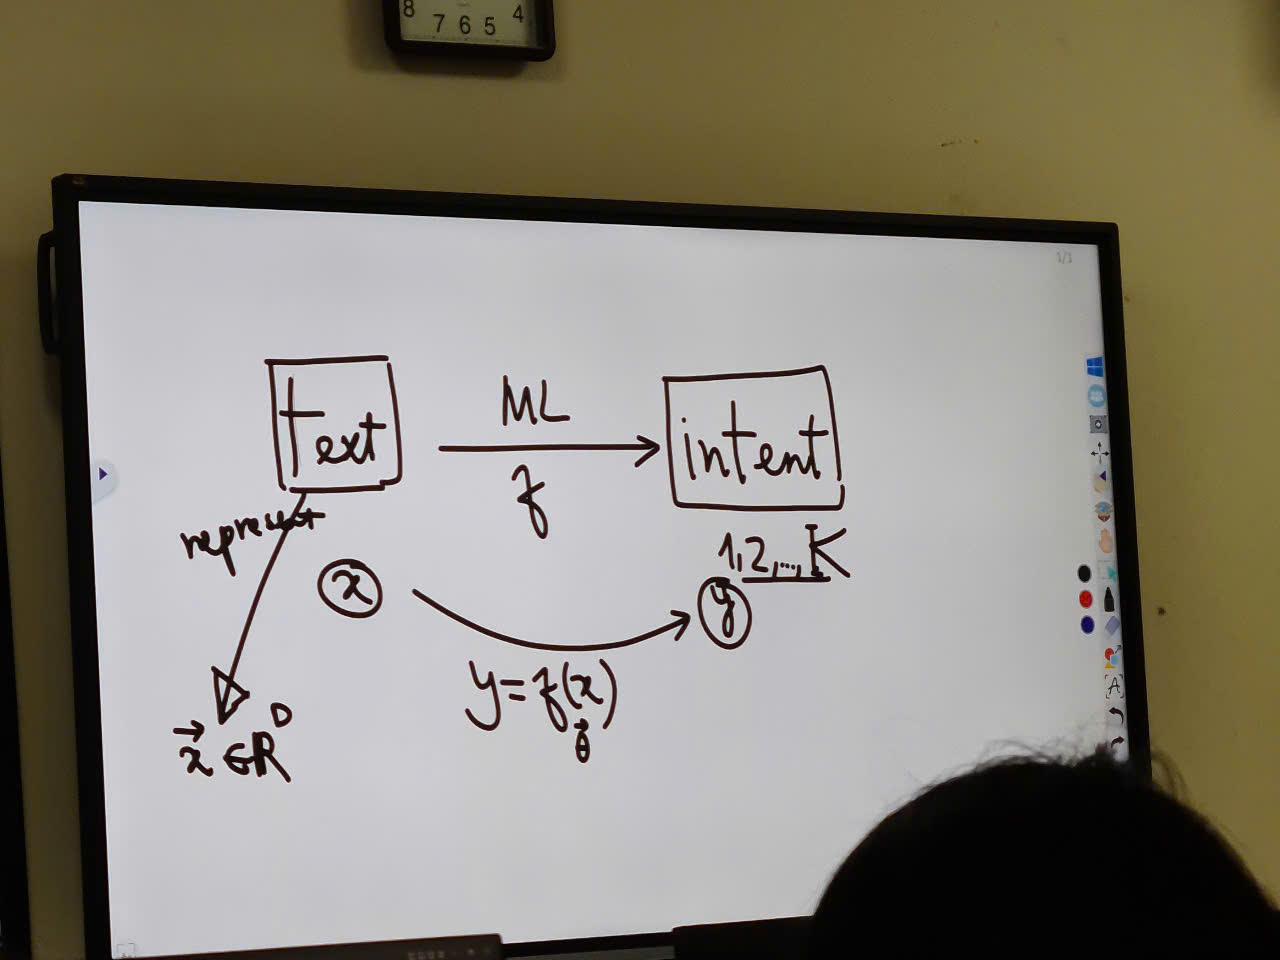

In [9]:
ef = df.select('intent','answer_normalised')

In [23]:
# Loại bỏ missing
ef = ef.dropna()

In [31]:
ef.count()

20818

In [24]:
# vectorize hóa văn bản đầu vào => phương pháp tách từ => tạo thành một xâu các từ
tokenizer = feature.Tokenizer().setInputCol('answer_normalised').setOutputCol('tokens')

In [25]:
# stringIndexer intent (label)
indexer = feature.StringIndexer().setInputCol('intent').setOutputCol('y')

In [27]:
# tạo pipeline 
pipeline = Pipeline(stages = [indexer, tokenizer])

In [32]:
# tạo object để fit pipeline cho tập dữ liệu
model = pipeline.fit(ef)

In [33]:
# transform để apply cho từng dòng của từng cột
ff = model.transform(ef)

In [34]:
ff.show(10, False)

+---------------+--------------------------------------------+----+----------------------------------------------------+
|intent         |answer_normalised                           |y   |tokens                                              |
+---------------+--------------------------------------------+----+----------------------------------------------------+
|set            |wake me up at five am this week             |1.0 |[wake, me, up, at, five, am, this, week]            |
|set            |wake me up at nine am on friday             |1.0 |[wake, me, up, at, nine, am, on, friday]            |
|set            |set an alarm for two hours from now         |1.0 |[set, an, alarm, for, two, hours, from, now]        |
|volume_mute    |quiet                                       |30.0|[quiet]                                             |
|volume_mute    |stop                                        |30.0|[stop]                                              |
|volume_mute    |pause for ten s

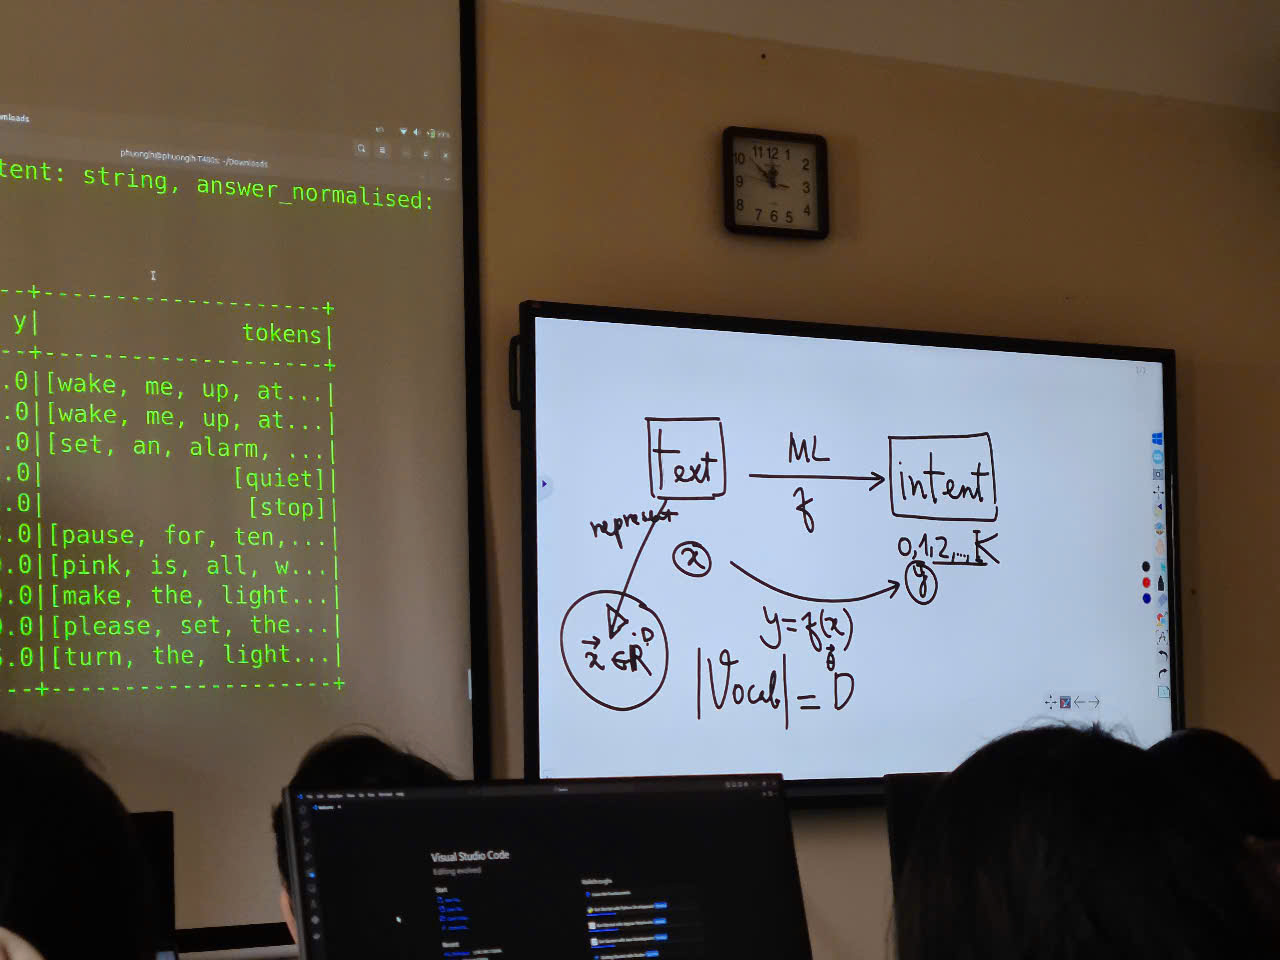

In [35]:
# vectorize bằng cách đếm cho tokens
vectorizer = feature.CountVectorizer().setInputCol('tokens').setOutputCol('x')

In [37]:
# Add thêm vectorize vào pipeline
pipeline = Pipeline(stages=[indexer, tokenizer, vectorizer])

In [38]:
# fit lại
model = pipeline.fit(ef)

In [39]:
ff = model.transform(ef)

In [43]:
ff.show(10)

+---------------+--------------------+----+--------------------+--------------------+
|         intent|   answer_normalised|   y|              tokens|                   x|
+---------------+--------------------+----+--------------------+--------------------+
|            set|wake me up at fiv...| 1.0|[wake, me, up, at...|(8068,[3,15,24,43...|
|            set|wake me up at nin...| 1.0|[wake, me, up, at...|(8068,[3,10,24,43...|
|            set|set an alarm for ...| 1.0|[set, an, alarm, ...|(8068,[8,16,32,38...|
|    volume_mute|               quiet|30.0|             [quiet]|  (8068,[796],[1.0])|
|    volume_mute|                stop|30.0|              [stop]|  (8068,[582],[1.0])|
|    volume_mute|pause for ten sec...|30.0|[pause, for, ten,...|(8068,[8,119,899,...|
|hue_lightchange| pink is all we need|21.0|[pink, is, all, w...|(8068,[2,46,55,23...|
|hue_lightchange|make the lighting...|21.0|[make, the, light...|(8068,[0,67,166,1...|
|hue_lightchange|please set the li...|21.0|[please, se

In [41]:
ff.printSchema()

root
 |-- intent: string (nullable = true)
 |-- answer_normalised: string (nullable = true)
 |-- y: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- x: vector (nullable = true)



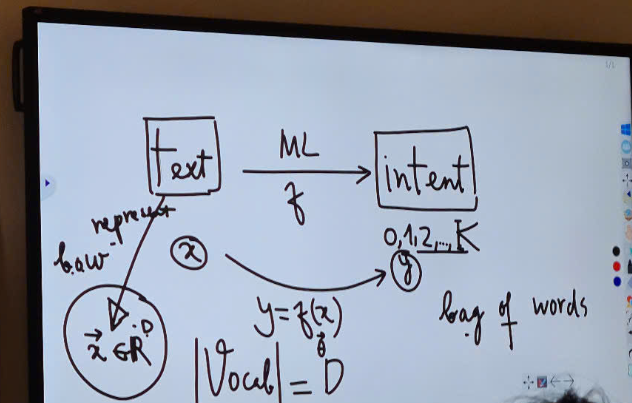

Phương pháp bag of word => nhét tất cả vào một túi => ko quan tâm đến thứ tự, nhưng có thể làm sai ý nghĩa của câu

In [45]:
# NOT ONE-HOT ENCODING => MULTI-HOT ENCODING
ff.select('x').head()
# Vector có 8086 chiều, các vị trí khác 0: 3, 15, 24, 43, 47, 69, 84, 293 : count sự xuất hiện (các từ khác 0 chỉ xuất hiện 1 lần)

Row(x=SparseVector(8068, {3: 1.0, 15: 1.0, 24: 1.0, 43: 1.0, 47: 1.0, 69: 1.0, 84: 1.0, 293: 1.0}))

In [46]:
ef.select('intent').distinct().count()

46

### Bước 2: Train model Classification trên toàn bộ tập dữ liệu

In [55]:
from pyspark.ml.classification import LogisticRegression

In [56]:
# Cột feature bắt buộc phải là một vector đã được vectorize hóa
classification = LogisticRegression(featuresCol="x", labelCol="y")

In [57]:
# Add thêm classification vào pipeline
pipeline = Pipeline(stages=[indexer, tokenizer, vectorizer, classification])

In [58]:
model = pipeline.fit(ef)

In [59]:
ff = model.transform(ef)

In [60]:
ff.printSchema()

root
 |-- intent: string (nullable = true)
 |-- answer_normalised: string (nullable = true)
 |-- y: double (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- x: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [62]:
ff.limit(10).toPandas().head(10)

,intent,answer_normalised,y,tokens,x,rawPrediction,probability,prediction
0,set,wake me up at five am this week,1.0,"[wake, me, up, at, five, am, this, week]","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[43.294052082689504, 59.965516919765186, -0.35...","[5.750091969492889e-08, 0.9999999424990789, 6....",1.0
1,set,wake me up at nine am on friday,1.0,"[wake, me, up, at, nine, am, on, friday]","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[34.58483559730733, 57.3764938093588, -5.30322...","[1.263888029682323e-10, 0.9999999897997848, 6....",1.0
2,set,set an alarm for two hours from now,1.0,"[set, an, alarm, for, two, hours, from, now]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[30.27541517650755, 67.40304846757167, 4.53358...","[7.51058448142329e-17, 1.0, 4.967511634276695e...",1.0
3,volume_mute,quiet,30.0,[quiet],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.231065134083845, -1.7016238532324408, 21.3...","[4.09966157145026e-34, 2.8083312019596724e-31,...",30.0
4,volume_mute,stop,30.0,[stop],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.078337915817276, -13.370214416306514, 23.3...","[3.2204106151619135e-19, 2.968250562739001e-23...",30.0
5,volume_mute,pause for ten seconds,30.0,"[pause, for, ten, seconds]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-1.1408918377371045, 11.901582778140764, 34.6...","[3.036363854426302e-37, 1.4016144585806179e-31...",30.0
6,hue_lightchange,pink is all we need,21.0,"[pink, is, all, we, need]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[14.742539610483867, -19.202316149367455, -2.8...","[1.031225363366646e-18, 1.8676265560739238e-33...",21.0
7,hue_lightchange,make the lighting bit more warm here,21.0,"[make, the, lighting, bit, more, warm, here]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[39.771120966353905, -22.328492417349633, 29.7...","[5.005237908652848e-19, 5.3691471208254105e-46...",21.0
8,hue_lightchange,please set the lighting suitable for reading,21.0,"[please, set, the, lighting, suitable, for, re...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-16.56461351496061, 1.8306821193009037, 0.802...","[1.003992393860166e-35, 9.788267050891252e-28,...",21.0
9,hue_lightoff,turn the lights off please,17.0,"[turn, the, lights, off, please]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-21.208718014345042, -16.79806420381129, 1.71...","[9.661114482008146e-36, 7.953345334302159e-34,...",17.0


In [63]:
ff.select('y', 'prediction').show()

+----+----------+
|   y|prediction|
+----+----------+
| 1.0|       1.0|
| 1.0|       1.0|
| 1.0|       1.0|
|30.0|      30.0|
|30.0|      30.0|
|30.0|      30.0|
|21.0|      21.0|
|21.0|      21.0|
|21.0|      21.0|
|17.0|      17.0|
|17.0|      17.0|
|42.0|      42.0|
|17.0|      17.0|
|33.0|      33.0|
|17.0|      17.0|
|21.0|      21.0|
|33.0|      33.0|
|33.0|      33.0|
|28.0|      28.0|
|28.0|      28.0|
+----+----------+
only showing top 20 rows



In [65]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [68]:
evaluator = MulticlassClassificationEvaluator().setLabelCol('y')
# Trung bình F1 của tất cả các nhãn

In [69]:
evaluator.evaluate(ff)

0.9936554084668017

### Bước 3: Train model trên 80 % tập dữ liệu

In [70]:
training, test = ef.randomSplit([0.8, 0.2], seed=1234)

In [71]:
model = pipeline.fit(training)

In [72]:
tf = model.transform(test)

In [73]:
tf.limit(10).toPandas().head(10)

,intent,answer_normalised,y,tokens,x,rawPrediction,probability,prediction
0,audiobook,audio,20.0,[audio],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.430525946932207, -0.9069120759344855, -7.1...","[5.493925161739762e-19, 5.063645359895649e-17,...",31.0
1,audiobook,base on my audiobook collection get me recomme...,20.0,"[base, on, my, audiobook, collection, get, me,...","(1.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[7.4995784579729765, -4.979373797386468, 39.19...","[3.718445458800778e-52, 1.4152113772262598e-57...",20.0
2,audiobook,continue audiobook playback,20.0,"[continue, audiobook, playback]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.16428054685179427, -1.2904858837619289, -7....","[5.642482313849017e-35, 1.317265062221633e-35,...",20.0
3,audiobook,continue playing my audiobook,20.0,"[continue, playing, my, audiobook]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[7.646539104864727, -0.6240175408806978, 11.39...","[7.42049259044423e-31, 1.8992215184216814e-34,...",20.0
4,audiobook,continue playing my book of vitamins,20.0,"[continue, playing, my, book, of, vitamins]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10010086664788398, -12.040886436121998, 19...","[7.143052537099179e-28, 4.6565745684335534e-33...",20.0
5,audiobook,continue pride and prejudice,20.0,"[continue, pride, and, prejudice]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.2676046617708625, -3.5104775955848035, 7.2...","[2.5277491520609602e-24, 5.389519906067321e-24...",20.0
6,audiobook,continue reading moby dick to me,20.0,"[continue, reading, moby, dick, to, me]","(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.571615032428168, 8.739587873087945, 14.498...","[7.766938301040126e-28, 2.5610010244544204e-20...",20.0
7,audiobook,go back to the midnight series,20.0,"[go, back, to, the, midnight, series]","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.488832091112402, 6.274965063956854, 2.4021...","[1.2390283126723669e-28, 1.592331260075195e-23...",12.0
8,audiobook,i want to listen to treasure island by robert ...,20.0,"[i, want, to, listen, to, treasure, island, by...","(0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[21.49653621665767, -3.1820071866647206, 26.20...","[0.008803849391489656, 1.6862322181971608e-13,...",2.0
9,audiobook,i want to resume where i last left off in my a...,20.0,"[i, want, to, resume, where, i, last, left, of...","(0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, ...","[-6.529093302964915, -43.91776452974496, 23.23...","[1.3237265560007615e-42, 7.657811680977051e-59...",20.0


In [74]:
evaluator.evaluate(tf)

0.77349083581834

In [75]:
tf.select('y', 'prediction').show(10)

+----+----------+
|   y|prediction|
+----+----------+
|20.0|      31.0|
|20.0|      20.0|
|20.0|      20.0|
|20.0|      20.0|
|20.0|      20.0|
|20.0|      20.0|
|20.0|      20.0|
|20.0|      12.0|
|20.0|       2.0|
|20.0|      20.0|
+----+----------+
only showing top 10 rows



In [84]:
ef.select('intent').groupBy('intent').count().withColumn('percentage', col('count')/ef.count()*100).sort('count', ascending=False).show()

+------------+-----+------------------+
|      intent|count|        percentage|
+------------+-----+------------------+
|       query| 5981|28.729945239696413|
|         set| 1748| 8.396579882793736|
|       music| 1205|5.7882601594773755|
|      quirky| 1058| 5.082140455375156|
|     factoid| 1052| 5.053319242962821|
|      remove|  986|  4.73628590642713|
|   sendemail|  694| 3.333653569026804|
|       radio|  551| 2.646748006532808|
|        post|  541| 2.598712652512249|
|  definition|  504|  2.42098184263618|
|      recipe|  415|1.9934671918532039|
|    podcasts|  379|1.8205399173791912|
|    currency|  378| 1.815736381977135|
|      events|  324| 1.556345470266116|
| createoradd|  294|1.4122394082044385|
|       stock|  270|1.2969545585550966|
|   locations|  257|1.2345085983283697|
|hue_lightoff|  246|1.1816697089057546|
|   audiobook|  241| 1.157652031895475|
|      ticket|  239|1.1480449610913632|
+------------+-----+------------------+
only showing top 20 rows



In [85]:
tf.show(20)

+---------+--------------------+----+--------------------+--------------------+--------------------+--------------------+----------+
|   intent|   answer_normalised|   y|              tokens|                   x|       rawPrediction|         probability|prediction|
+---------+--------------------+----+--------------------+--------------------+--------------------+--------------------+----------+
|audiobook|               audio|20.0|             [audio]|  (7224,[340],[1.0])|[-5.4305259469322...|[5.49392516173976...|      31.0|
|audiobook|base on my audiob...|20.0|[base, on, my, au...|(7224,[0,2,4,5,10...|[7.49957845797297...|[3.71844545880077...|      20.0|
|audiobook|continue audioboo...|20.0|[continue, audiob...|(7224,[287,632,96...|[0.16428054685179...|[5.64248231384901...|      20.0|
|audiobook|continue playing ...|20.0|[continue, playin...|(7224,[4,144,287,...|[7.64653910486472...|[7.42049259044423...|      20.0|
|audiobook|continue playing ...|20.0|[continue, playin...|(7224,[4,11

### Bước 3: Hiệu chỉnh 

In [ ]:
# vectorize bằng cách đếm cho tokens => set một ngưỡng cho 1 từ phải xuất hiện ít nhất 2 lần => tránh trg hợp gõ sai làm phình số chiều của vector ra
vectorizer = feature.CountVectorizer().setInputCol('tokens').setOutputCol('x').setMinDF(2)

In [86]:
# Add thêm classification vào pipeline
pipeline = Pipeline(stages=[indexer, tokenizer, vectorizer, classification])

In [87]:
model = pipeline.fit(training)

In [88]:
tf = model.transform(test)

In [89]:
evaluator.evaluate(tf)

0.77349083581834

In [90]:
# Số tham số
46*3525

162150

### Lấy thông tin về Vocab

In [91]:
model

PipelineModel_284c00e97435

In [92]:
# Model là một pipeline => Lấy danh sách các stages ra
model.stages

[StringIndexerModel: uid=StringIndexer_24428972a995, handleInvalid=error,
 Tokenizer_d421e0d42afa,
 CountVectorizerModel: uid=CountVectorizer_aafb29ae28ac, vocabularySize=7224,
 LogisticRegressionModel: uid=LogisticRegression_9c67fd5d8041, numClasses=46, numFeatures=7224]

In [96]:
model.stages[2]

CountVectorizerModel: uid=CountVectorizer_aafb29ae28ac, vocabularySize=7224

In [106]:
# Display vocabulary (specific to CountVectorizerModel)
model.stages[2].vocabulary

# if isinstance(model.stages[2], CountVectorizerModel):
#     print("Vocabulary:", model.stages[2].vocabulary)

['the',
 'to',
 'me',
 'is',
 'my',
 'i',
 'what',
 'a',
 'for',
 'in',
 'on',
 'of',
 'please',
 'play',
 'you',
 'this',
 'from',
 'and',
 'how',
 'list',
 'today',
 'do',
 'at',
 'can',
 'tell',
 'email',
 'new',
 'time',
 'have',
 'are',
 'about',
 'it',
 'set',
 '<unk>',
 'with',
 'any',
 'meeting',
 'an',
 'next',
 'song',
 'turn',
 'calendar',
 'news',
 'am',
 'that',
 'event',
 'up',
 'need',
 'weather',
 'lights',
 'music',
 'all',
 'want',
 'pm',
 'off',
 'send',
 "what's",
 'add',
 'train',
 'be',
 'one',
 'alarm',
 'will',
 'there',
 'like',
 'make',
 'get',
 'show',
 'week',
 'events',
 'now',
 'when',
 'remind',
 'two',
 'emails',
 'day',
 'does',
 'by',
 'tomorrow',
 'start',
 'find',
 'remove',
 'give',
 'where',
 'current',
 'radio',
 'five',
 'latest',
 'going',
 'check',
 'some',
 'know',
 'book',
 'go',
 'last',
 'tweet',
 'hundred',
 'delete',
 'open',
 'playlist',
 'many',
 'podcast',
 'reminder',
 'twenty',
 'would',
 'was',
 'order',
 'light',
 'ticket',
 'three

In [108]:
model.stages[0].labels

['query',
 'set',
 'music',
 'quirky',
 'factoid',
 'remove',
 'sendemail',
 'post',
 'radio',
 'definition',
 'recipe',
 'currency',
 'podcasts',
 'events',
 'createoradd',
 'locations',
 'hue_lightoff',
 'stock',
 'game',
 'ticket',
 'audiobook',
 'hue_lightchange',
 'order',
 'coffee',
 'likeness',
 'querycontact',
 'traffic',
 'taxi',
 'cleaning',
 'maths',
 'volume_mute',
 'volume_up',
 'hue_lightup',
 'hue_lightdim',
 'joke',
 'movies',
 'wemo_off',
 'convert',
 'addcontact',
 'wemo_on',
 'settings',
 'volume_down',
 'hue_lighton',
 'dislikeness',
 'greet',
 'volume_other']

### Bài tập về nhà: Thay thuật toán khác cho Logistic Regression: RF, DT, Neuron